In [1]:
import pandas as pd

In [2]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_cats.txt

--2021-12-27 16:02:38--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228391 (223K) [text/plain]
Saving to: ‘train_aspects.txt’

train_aspects.txt   100%[===================>] 223.04K  --.-KB/s    in 0.03s   

2021-12-27 16:02:38 (8.55 MB/s) - ‘train_aspects.txt’ saved [228391/228391]

--2021-12-27 16:02:38--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [3]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_aspects.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_cats.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_pred_aspects.txt

--2021-12-27 16:02:41--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57508 (56K) [text/plain]
Saving to: ‘dev_aspects.txt’

dev_aspects.txt     100%[===================>]  56.16K  --.-KB/s    in 0.01s   

2021-12-27 16:02:42 (5.08 MB/s) - ‘dev_aspects.txt’ saved [57508/57508]

--2021-12-27 16:02:42--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

In [35]:
! pip install pymorphy2

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 1.0 MB/s 


In [43]:
import pandas as pd
import numpy as np

from collections import Counter
import re

import pymorphy2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import statistics
import seaborn as sn
import matplotlib.pyplot  as plt
from sklearn.metrics import classification_report, confusion_matrix

from time import time


import joblib
import json

In [38]:
train_asp = pd.read_csv(
    'train_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_reviews.txt', delimiter='\t', names=['text_id','text'])


test_asp = pd.read_csv(
    'dev_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
test_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id','text'])

In [44]:
def text_cls(CLS_ALGORITHM,X_train,  y_train, X_test, y_test, path_save):
    if CLS_ALGORITHM == 'LogisticRegression':
        nb =  Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', LogisticRegression())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
                         'clf__penalty': ( "l1", "l2"),
                         'clf__C': (1.5, 1, 0.5),
                         'clf__class_weight': ['balanced']}
 
    elif CLS_ALGORITHM == 'MultinomialNB':
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf',MultinomialNB())])
        parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__alpha': ( 0.01, 0.001)}
    elif CLS_ALGORITHM == 'RandomForestClassifier':   
        nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', RandomForestClassifier())])
 
 
        parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'clf__class_weight': ("balanced", "balances_subsample")}
    else:
      nb = Pipeline([('vectorizer', TfidfVectorizer(use_idf=True,
                                                 smooth_idf=True,
                                                 sublinear_tf=True)),
                ('clf', PassiveAggressiveClassifier())])
      parameters_nb = {'vectorizer__ngram_range': [(1, 2), (2,2)],
               'clf__max_iter': ( 1000, 2000),
               'clf__C': (1.5, 1, 0.5),} 

    gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")

    
    gs_clf_nb = gs_clf_nb.fit(X_train.to_list(), y_train.to_list())
    print(gs_clf_nb.best_score_)
    print(gs_clf_nb.best_params_)
    r = gs_clf_nb.best_estimator_
    predicted = r.predict(X_test.to_list())
    joblib.dump(r, f'{path_save}_{CLS_ALGORITHM}.pkl')
    return y_test, predicted

In [45]:
def visualize(y_true, y_pred, df, target_column, new_path):
    plt.figure(figsize=(7,5))
    array=confusion_matrix(y_true, y_pred)
    a = [sorted(df[target_column].unique())]
    df_cm = pd.DataFrame(array, index=a, columns=a)
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
    plt.xticks(rotation=60)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Реальный класс')
    plt.savefig(new_path + '_'+ 'image.png')
    plt.show()


0.6010391831988138
{'clf__C': 0.5, 'clf__max_iter': 2000, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

        both       0.57      0.42      0.48        19
    negative       0.84      0.47      0.61       160
     neutral       0.70      0.65      0.67       216
    positive       0.83      0.93      0.88       795

    accuracy                           0.81      1190
   macro avg       0.74      0.62      0.66      1190
weighted avg       0.81      0.81      0.80      1190



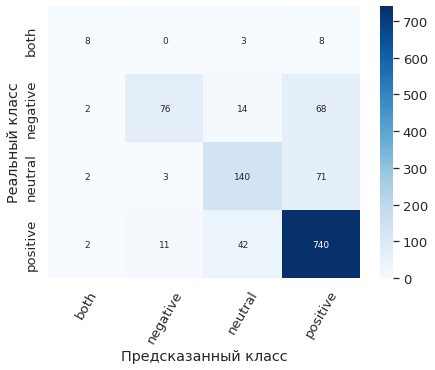

In [46]:
y_test, predicted = text_cls('PassiveAggressiveClassifier',train_asp['mention'],  train_asp['sentiment'], test_asp['mention'], test_asp['sentiment'], './')
print(classification_report(y_test, predicted))
visualize(y_test, predicted, train_asp, 'sentiment', './')


In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

0.8100840336134454